In [6]:
import numpy as np
import pandas as pd
import re
from scipy.stats import norm

from matplotlib import pyplot as plt
from data_util import create_dataset
from sklearn.preprocessing import StandardScaler
from scipy.stats import ttest_ind
from sklearn.cluster import DBSCAN

import math
pd.options.display.max_rows = 100
pd.set_option('display.max_rows', None)

# Read in data

###  Note that the loaded data has already been log_2(x+1) transformed from the raw values

In [7]:
# Read in new data
filepath_new = '../mmc1-tony.xlsx'
data_new = pd.read_excel(filepath_new,index_col=0)

In [8]:
data_BRCA_lung = create_dataset(cancer_type = 'BRCA',
                                new_tumor_event_site = 'Lung',
                                data_new = data_new,
                                filepath_ge = '../BRCA/TCGA-BRCA.htseq_fpkm.tsv',
                                filepath_ph = '../BRCA/TCGA-BRCA.GDC_phenotype.tsv')

In [9]:
data_BRCA_lung

,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,...,ENSG00000273233.1,ENSG00000105063.17,ENSG00000231119.2,ENSG00000280861.1,ENSG00000123685.7,ENSG00000181518.3,sample_id,bcr_patient_barcode,new_tumor_event_site,sample_type.samples
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A3XS-01A,0.000000,0.000000,2.188195,0.000000,1.748448,3.943407,0.000000,0.016324,7.308638,0.000000,...,0.195737,3.972232,0.349083,0.0,0.986316,0.0,TCGA-A2-A3XS-01A,TCGA-A2-A3XS,Lung,Primary Tumor
TCGA-B6-A409-01A,0.000000,0.000000,1.592924,0.000000,0.907229,3.270728,0.071389,0.157954,7.320173,0.078148,...,0.000000,3.448320,0.279186,0.0,1.320473,0.0,TCGA-B6-A409-01A,TCGA-B6-A409,Lung,Primary Tumor
TCGA-B6-A0I1-01A,0.000000,0.008025,1.566140,0.000000,2.080369,2.726910,0.000000,0.169888,8.075526,0.026461,...,0.047540,2.601373,1.057151,0.0,0.992014,0.0,TCGA-B6-A0I1-01A,TCGA-B6-A0I1,Lung,Primary Tumor
TCGA-BH-A1EY-01A,0.000000,0.006257,2.287106,0.000000,2.294679,3.938652,0.000000,0.941261,6.955325,0.080917,...,0.000000,4.374549,0.331327,0.0,0.600684,0.0,TCGA-BH-A1EY-01A,TCGA-BH-A1EY,Lung,Primary Tumor
TCGA-EW-A1P1-01A,0.091184,0.000000,1.680844,0.000000,2.855336,3.267594,0.000000,0.011125,7.184775,0.239088,...,0.000000,3.762484,0.222120,0.0,1.516585,0.0,TCGA-EW-A1P1-01A,TCGA-EW-A1P1,Lung,Primary Tumor
TCGA-AR-A5QQ-01A,0.000000,0.000000,2.050921,0.000000,2.513511,3.040755,0.000000,0.108066,7.331879,0.253488,...,0.000000,3.947990,0.097843,0.0,1.293070,0.0,TCGA-AR-A5QQ-01A,TCGA-AR-A5QQ,Lung,Primary Tumor
TCGA-E2-A1LE-01A,0.072704,0.000000,2.326930,0.000000,2.295381,3.601933,0.000000,0.005299,8.107163,0.162199,...,0.000000,3.741809,0.071371,0.0,0.915310,0.0,TCGA-E2-A1LE-01A,TCGA-E2-A1LE,Lung,Primary Tumor
TCGA-EW-A1P8-01A,0.000000,0.000000,1.749768,0.000000,3.565526,3.109890,0.000000,0.006606,6.917720,0.031766,...,0.056990,5.003280,0.318117,0.0,0.620852,0.0,TCGA-EW-A1P8-01A,TCGA-EW-A1P8,Lung,Primary Tumor
TCGA-3C-AAAU-01A,0.000000,0.000000,2.225387,0.000000,1.498832,3.771037,0.000000,0.004982,7.086283,0.031925,...,0.057271,4.464153,0.308488,0.0,0.326940,0.0,TCGA-3C-AAAU-01A,TCGA-3C-AAAU,Lung,Primary Tumor


In [10]:
### Selecting genes related to transporters and enzymes

In [11]:
col_trunc_list = [x[:15] for x in data_BRCA_lung.columns[:-4]]
col_trunc_df = pd.DataFrame(col_trunc_list)
col_trunc_df = pd.concat([col_trunc_df,pd.DataFrame(data_BRCA_lung.columns[:-4])],axis=1)
col_trunc_df.columns = ['ensembl_gene_id','og_index']

In [13]:
names_df = pd.read_csv('../ensembl_index.csv',index_col = 0)
final_names = pd.merge(names_df,col_trunc_df)

In [14]:
gene_list = final_names.og_index.tolist()

In [15]:
feature_list = gene_list + ['sample_id', 'bcr_patient_barcode', 'new_tumor_event_site','sample_type.samples']

In [16]:
u,c = np.unique(feature_list,return_counts=True)
u[c>1]

array(['ENSG00000099977.12', 'ENSG00000100197.19', 'ENSG00000104205.11',
       'ENSG00000104237.6', 'ENSG00000112541.12', 'ENSG00000114316.11',
       'ENSG00000114374.11', 'ENSG00000124713.5', 'ENSG00000128383.11',
       'ENSG00000130035.5', 'ENSG00000133816.12', 'ENSG00000137843.10',
       'ENSG00000160209.17', 'ENSG00000163156.10', 'ENSG00000172352.5',
       'ENSG00000182415.9', 'ENSG00000223443.2', 'ENSG00000241370.4',
       'ENSG00000257365.6'], dtype='<U20')

In [17]:
data_BRCA_lung = data_BRCA_lung[feature_list]
data_BRCA_lung = data_BRCA_lung.loc[:,~data_BRCA_lung.columns.duplicated()]

In [18]:
data_BRCA_lung.drop('TCGA-E9-A1NF-11A',inplace=True)

### Histogram

In [19]:
X_df = data_BRCA_lung.drop(columns=['sample_id','bcr_patient_barcode','new_tumor_event_site',])
X_tumor_df = X_df[X_df['sample_type.samples']=="Primary Tumor"]
X_tumor_df = X_tumor_df.drop(columns = 'sample_type.samples')
# scaler = StandardScaler()
# scaler.fit_transform(X_tumor_df)
# X_scaled = scaler.transform(X_tumor_df)
# mean_vec = scaler.mean_
# var_vec = scaler.var_

In [20]:
mean_vec = X_tumor_df.mean()

Text(0.5, 0, 'Mean')

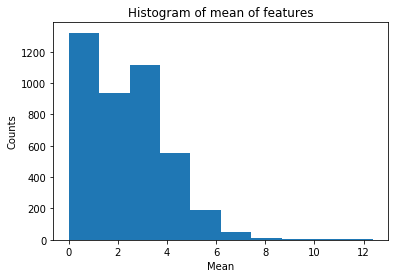

In [21]:
plt.hist(mean_vec)

plt.title('Histogram of mean of features')
plt.ylabel('Counts')
plt.xlabel('Mean')

Text(0.5, 0, 'Mean')

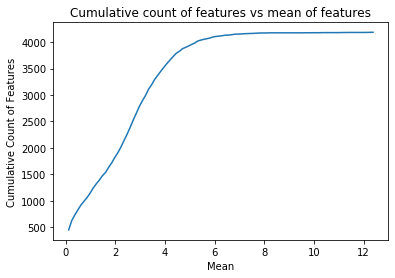

In [22]:
hist, bin_edges = np.histogram(mean_vec,bins=100)
plt.plot(bin_edges[1:],np.cumsum(hist))
plt.title('Cumulative count of features vs mean of features')
plt.ylabel('Cumulative Count of Features')
plt.xlabel('Mean')

## Standardize

In [23]:
# X_df = data_BRCA_lung.drop(columns=['sample_id','bcr_patient_barcode','new_tumor_event_site',])
# X_tumor_df = X_df[X_df['sample_type.samples']=="Primary Tumor"]
# X_tumor_df = X_tumor_df.drop(columns = 'sample_type.samples')
# scaler = StandardScaler()
# scaler.fit_transform(X_tumor_df)
# X_scaled = pd.DataFrame(scaler.transform(X_tumor_df))
# X_scaled.columns = X_tumor_df.columns
# X_scaled.index = X_tumor_df.index

## Drop according to mean and variance of each feature (This is currently not working, skip this part

In [24]:
'''
mean_vec = scaler.mean_
var_vec = scaler.var_
cutoff_num = 6 # We want 1-cutoff_prob of the distribution to be above this number
cutoff_prob=.05
keep_vec = []
zeros_vec = []
nan_vec = []
for ii in range(len(mean_vec)):
    mean = mean_vec[ii]
    variance = var_vec[ii]
    distribution = norm(loc=mean,scale=variance)
    cum_prob = distribution.cdf(cutoff_num)
    if np.isnan(cum_prob):
        nan_vec.append(ii)
    if cum_prob >= cutoff_prob: # Drop when cutoff_prob
        keep_vec.append(ii)
    if (mean_vec[ii] == 0) or (var_vec[ii] == 0):
        zeros_vec.append(ii)
    else:
        pass
'''

'\nmean_vec = scaler.mean_\nvar_vec = scaler.var_\ncutoff_num = 6 # We want 1-cutoff_prob of the distribution to be above this number\ncutoff_prob=.05\nkeep_vec = []\nzeros_vec = []\nnan_vec = []\nfor ii in range(len(mean_vec)):\n    mean = mean_vec[ii]\n    variance = var_vec[ii]\n    distribution = norm(loc=mean,scale=variance)\n    cum_prob = distribution.cdf(cutoff_num)\n    if np.isnan(cum_prob):\n        nan_vec.append(ii)\n    if cum_prob >= cutoff_prob: # Drop when cutoff_prob\n        keep_vec.append(ii)\n    if (mean_vec[ii] == 0) or (var_vec[ii] == 0):\n        zeros_vec.append(ii)\n    else:\n        pass\n'

# Drop according to mean (Drop if mean < 6, keep if mean >=6)

In [25]:
X_filtered = X_tumor_df[X_tumor_df.columns[mean_vec>=2]]

In [26]:
X_filtered.head()

,ENSG00000000419.11,ENSG00000000938.11,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001561.6,ENSG00000001629.8,ENSG00000002549.11,ENSG00000003509.14,ENSG00000003989.15,ENSG00000004455.15,...,ENSG00000272325.1,ENSG00000272333.4,ENSG00000275074.1,ENSG00000276023.3,ENSG00000276043.3,ENSG00000276293.3,ENSG00000277791.3,ENSG00000278053.3,ENSG00000278540.3,ENSG00000278619.3
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A3XS-01A,5.661970,2.054464,4.647208,2.221728,2.978367,3.291049,4.586103,2.701784,0.911466,4.831395,...,2.452775,3.684723,1.837284,3.770344,3.208604,4.017068,6.577528,2.354127,2.829414,2.217264
TCGA-B6-A409-01A,7.125106,1.184212,5.041745,2.322211,2.123892,2.688222,4.559158,2.300412,0.837693,4.735272,...,2.663017,2.659067,2.300588,3.849787,1.534177,2.841454,7.137501,1.941013,2.015007,3.066920
TCGA-B6-A0I1-01A,5.243776,0.692619,4.674519,2.393131,1.982541,3.236770,4.147502,2.601671,0.098163,5.930779,...,2.467281,3.412525,1.401475,4.330974,1.268508,4.126603,8.217482,2.652238,3.906099,4.148813
TCGA-BH-A1EY-01A,4.841724,3.955375,5.286194,2.818560,3.298148,3.953702,4.916584,1.886928,3.712448,4.394373,...,1.782670,2.331399,2.417935,2.971519,1.622531,3.520133,5.758548,1.660829,2.721171,0.849916
TCGA-EW-A1P1-01A,4.757029,3.012064,4.601565,2.625235,2.394472,3.528331,5.460453,2.110321,3.486097,4.189100,...,1.813016,2.715929,2.035503,3.956387,1.986292,4.025924,5.978185,2.378502,3.461025,1.334375


In [27]:
breast_genes_c = [gene for gene in X_filtered.columns]
breast_genes_c_trunc = [x[:15] for x in breast_genes_c]

In [28]:
len(breast_genes_c_trunc), len(np.unique(breast_genes_c_trunc))

(2361, 2361)

In [29]:
BRCA_lung_trunc_df = X_filtered
BRCA_lung_trunc_df.columns = breast_genes_c_trunc

# Differential Gene Expression Analysis

In [30]:
# Read in healthy origin site data (breast in this case)
healthy_breast_df = pd.read_csv('../breast_ge_healthy.csv',index_col=0)
healthy_breast_df = healthy_breast_df.set_index('sample').T

In [31]:
def rescale_log(x):
    '''
    The GTEX data uses log_2(fpkm+.001), while the TCGA data uses log_2(fpkm+1).
    We are going to rescale the GTEX data to log_2(fpkm+.1)
    '''
    new_x = math.log(pow(2,x)-.001+1,2)
    return new_x

In [32]:
def rescale_log(x):
    '''
    The GTEX data uses log_2(fpkm+.001), while the TCGA data uses log_2(fpkm+1).
    We are going to rescale the GTEX data to log_2(fpkm+.1)
    '''
    new_x = math.log(pow(2,x)-.001+1,2)
    return new_x
healthy_breast_df = healthy_breast_df.applymap(rescale_log)

In [33]:
breast_genes_h = [genes for genes in healthy_breast_df.columns]
breast_genes_h_trunc = [x[:15] for x in breast_genes_h]

In [34]:
len(breast_genes_h_trunc), len(np.unique(breast_genes_h_trunc))

(60498, 60498)

In [35]:
gene_int = set(breast_genes_c_trunc).intersection(set(breast_genes_h_trunc))
len(gene_int)

2361

In [36]:
healthy_breast_trunc_df = healthy_breast_df
healthy_breast_trunc_df.columns = breast_genes_h_trunc
# healthy_breast_trunc_df = healthy_breast_trunc_df[breast_genes_c_trunc]

In [37]:
# Loop through all genes for two-sample t-test
gene_list = []
mean_ge_list = []

for gene in breast_genes_c_trunc:
    t, p = ttest_ind(healthy_breast_trunc_df[gene], BRCA_lung_trunc_df[gene], equal_var=False)
    h_mean = healthy_breast_trunc_df[gene].mean()
    c_mean = BRCA_lung_trunc_df[gene].mean()
    
    
    if p < 0.005 and c_mean > h_mean:
        gene_list.append(gene)
        mean_ge_list.append((c_mean, h_mean,c_mean-h_mean))

In [38]:
len(gene_list), len(breast_genes_c_trunc)

(228, 2361)

# CLUSTERING ATTEMPT, K-clique

In [48]:
from networkx.algorithms.community.kclique import k_clique_communities
from networkx import Graph, find_cliques
import networkx

In [59]:
# healthy_breast_signif = healthy_breast_trunc_df[gene_list]
# gene_index = healthy_breast_trunc_df.columns
BRCA_lung_subset_df = BRCA_lung_trunc_df[gene_list]
gene_index = BRCA_lung_subset_df.columns

In [60]:
BRCA_lung_subset_df.head()

,ENSG00000004478,ENSG00000005022,ENSG00000009954,ENSG00000012963,ENSG00000021574,ENSG00000033100,ENSG00000041353,ENSG00000044574,ENSG00000055332,ENSG00000059573,...,ENSG00000198380,ENSG00000198833,ENSG00000198890,ENSG00000198900,ENSG00000198951,ENSG00000203805,ENSG00000221955,ENSG00000247077,ENSG00000263528,ENSG00000276043
sample_id,,,,,,,,,,,,,,,,,,,,,
TCGA-A2-A3XS-01A,5.968574,7.995892,4.299385,3.565845,3.217735,4.610275,2.357547,7.075339,3.714093,4.756603,...,4.636710,4.337187,3.294028,4.916659,3.234199,2.219904,3.437248,4.027772,2.746514,3.208604
TCGA-B6-A409-01A,5.742388,7.554712,4.563727,2.837079,2.681880,5.158118,1.082915,7.596579,2.814432,5.087521,...,4.805277,4.911235,3.109994,5.052279,3.646404,2.608090,2.612141,4.471829,3.738415,1.534177
TCGA-B6-A0I1-01A,6.240744,7.867117,3.654257,3.393935,2.470359,3.801976,1.153896,8.133472,3.332018,4.388241,...,4.188892,4.309306,1.588621,4.772544,4.071742,0.720380,2.586778,4.645532,3.730373,1.268508
TCGA-BH-A1EY-01A,7.189604,7.410948,4.438626,3.683499,2.898978,4.719696,3.225243,7.030286,3.393360,6.522008,...,4.168877,4.413882,2.401816,5.335791,4.622447,3.002610,1.964349,3.377422,2.485236,1.622531
TCGA-EW-A1P1-01A,5.448431,7.276215,4.332615,3.717147,2.633959,4.358241,2.232434,7.693373,3.515239,4.615431,...,3.749057,4.835745,3.117079,5.177466,4.092709,2.158505,2.486066,3.508351,1.948345,1.986292


In [100]:
gene_array = BRCA_lung_subset_df.to_numpy()
corr = np.corrcoef(gene_array.T)
corr_filtered = (corr > .8)

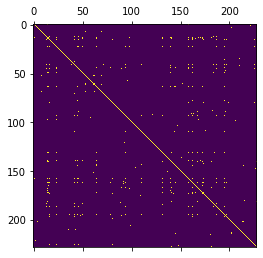

In [101]:
plt.matshow(corr_filtered)

In [89]:
# (sum(sum(corr_filtered))-239)/2 + 239

In [102]:
gene_network = Graph(corr_filtered)

In [103]:
print(gene_network.number_of_edges())
print(gene_network.number_of_nodes())

409
228


In [104]:
# fc = networkx.find_cliques(gene_network)

# len(list(fc))

In [105]:
# networkx.draw_random(gene_network)

In [106]:
gene_clusters = k_clique_communities(gene_network,2,networkx.find_cliques(gene_network))

In [107]:
clusters_list = list(gene_clusters)

In [122]:
gene2idx = {}
idx2gene = {}

for i, gene in enumerate(gene_list):
    gene2idx[gene] = i
    idx2gene[i] = gene

In [108]:
gene_cluster_count = []

for cluster in clusters_list:
    genes_in_cluster = gene_index[list(cluster)]
    gene_cluster_count.append()
    print(genes_in_cluster)

Index(['ENSG00000005022', 'ENSG00000149554', 'ENSG00000021574',
       'ENSG00000156802', 'ENSG00000156970', 'ENSG00000072506',
       'ENSG00000073111', 'ENSG00000160957', 'ENSG00000077152',
       'ENSG00000162639', 'ENSG00000162607', 'ENSG00000162396',
       'ENSG00000076003', 'ENSG00000087586', 'ENSG00000165304',
       'ENSG00000166851', 'ENSG00000102100', 'ENSG00000102172',
       'ENSG00000167114', 'ENSG00000167900', 'ENSG00000168078',
       'ENSG00000103257', 'ENSG00000104524', 'ENSG00000168411',
       'ENSG00000104549', 'ENSG00000104738', 'ENSG00000104889',
       'ENSG00000170312', 'ENSG00000169679', 'ENSG00000105612',
       'ENSG00000106462', 'ENSG00000171848', 'ENSG00000172336',
       'ENSG00000173456', 'ENSG00000175063', 'ENSG00000112118',
       'ENSG00000178999', 'ENSG00000179115', 'ENSG00000179750',
       'ENSG00000179958', 'ENSG00000116120', 'ENSG00000181192',
       'ENSG00000116863', 'ENSG00000117650', 'ENSG00000183665',
       'ENSG00000187605', 'ENSG000001883

In [109]:
len(clusters_list[0]), len(clusters_list)

53

In [126]:
# networkx.draw_random(gene_network[0])

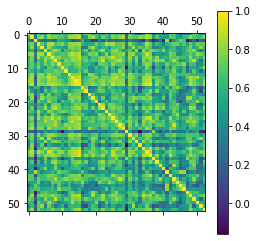

In [137]:
df = np.corrcoef(gene_array.T[list(clusters_list[0])])
plt.matshow(df)
# plt.xticks(range(len(df.columns)), df.columns)
# plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()
plt.show()

In [131]:
list(clusters_list[0])

[1,
 131,
 4,
 139,
 140,
 13,
 14,
 142,
 16,
 145,
 144,
 143,
 15,
 23,
 158,
 162,
 36,
 37,
 165,
 167,
 168,
 39,
 42,
 170,
 43,
 45,
 46,
 173,
 172,
 48,
 50,
 181,
 183,
 184,
 186,
 64,
 194,
 195,
 196,
 198,
 71,
 202,
 78,
 80,
 210,
 213,
 214,
 90,
 94,
 225,
 98,
 227,
 110]

# K-means Clustering

In [112]:
from sklearn.cluster import KMeans
from sklearn import preprocessing

# Keep subset of genes that are effectively upregulated
BRCA_lung_subset_df = BRCA_lung_trunc_df[gene_list]

BRCA_lung_subset_df.shape

gene_array = BRCA_lung_subset_df.to_numpy()

# gene_array

gene_array_norm = preprocessing.normalize(gene_array.T)

gene_list = np.array(gene_list)

cluster_count = 20
km2 = KMeans(n_clusters=cluster_count,init='random').fit(gene_array_norm)

In [113]:
for i in range(cluster_count):
    print('----------Cluster {}----------'.format(i))
    print(gene_list[km2.labels_==i])

----------Cluster 0----------
['ENSG00000135094' 'ENSG00000135750' 'ENSG00000182580' 'ENSG00000263528']
----------Cluster 1----------
['ENSG00000111110' 'ENSG00000134602']
----------Cluster 2----------
['ENSG00000078237' 'ENSG00000100985' 'ENSG00000104951' 'ENSG00000136159'
 'ENSG00000155380' 'ENSG00000182866']
----------Cluster 3----------
['ENSG00000004478' 'ENSG00000021574' 'ENSG00000055332' 'ENSG00000084073'
 'ENSG00000086232' 'ENSG00000102100' 'ENSG00000107815' 'ENSG00000111667'
 'ENSG00000116096' 'ENSG00000116199' 'ENSG00000121644' 'ENSG00000124786'
 'ENSG00000136628' 'ENSG00000137364' 'ENSG00000138018' 'ENSG00000139514'
 'ENSG00000143799' 'ENSG00000162813' 'ENSG00000163624' 'ENSG00000170881'
 'ENSG00000175073' 'ENSG00000181192' 'ENSG00000183665' 'ENSG00000187605'
 'ENSG00000198380' 'ENSG00000221955']
----------Cluster 4----------
['ENSG00000012963' 'ENSG00000065923' 'ENSG00000100522' 'ENSG00000116133'
 'ENSG00000116704' 'ENSG00000119401' 'ENSG00000119408' 'ENSG00000122884'
 'ENS

In [121]:
km2.cluster_centers_

array([[0.28303473, 0.30577976, 0.27363402, 0.24685828, 0.22212854,
        0.21194273, 0.23188939, 0.32813178, 0.2211669 , 0.38054971,
        0.19308917, 0.19727358, 0.1084732 , 0.20307043, 0.27401997],
       [0.27170579, 0.25424932, 0.32689568, 0.22812143, 0.22485679,
        0.13016219, 0.18464114, 0.28744766, 0.24711279, 0.18633445,
        0.52752953, 0.18587986, 0.15692526, 0.18139194, 0.17689484],
       [0.24089299, 0.18746193, 0.23561562, 0.24362532, 0.27338177,
        0.33387511, 0.26663061, 0.33992287, 0.14603431, 0.22632562,
        0.2183571 , 0.23363856, 0.24824615, 0.21126867, 0.30247063],
       [0.27354191, 0.27922643, 0.26539937, 0.2721942 , 0.24951369,
        0.21927909, 0.25368042, 0.28965286, 0.26876804, 0.27081234,
        0.27254392, 0.22781512, 0.21259273, 0.2279753 , 0.24986712],
       [0.21478166, 0.20872616, 0.25624505, 0.28605907, 0.26265609,
        0.25477745, 0.27355834, 0.28240455, 0.2584918 , 0.26700691,
        0.29631528, 0.2424536 , 0.23895872, 